In [1]:
import pandas as pd
from sqlalchemy import create_engine
import statistics
import matplotlib.pyplot as plt

database_path = 'storage.sqlite'

engine = create_engine(f'sqlite:///{database_path}')
con = engine.connect()

df_gamedata = pd.read_sql('SELECT * FROM gamedata', con)
df_gamedata_original = pd.read_sql('SELECT * FROM gamedata', con)

con.close()

df = pd.read_csv('PATCH_13.1_9500_GAMES.csv')

df_gamedata['summonerName'] = df_gamedata['summonerName'].replace({
    'The Life of Andy': 'Andy',
    'Fer Sharks': 'Jackson',
    'Diet Smite': 'Kori',
    'Santa kums 2nite': 'Kori',
    'B1ng Chillin': 'Kori',
    'Brony Hole': 'Luke',
    'cloaca buss down': 'Rob',
    'glocktobussy': 'Tonnie',
    'BeaIs': 'Beals',
    'Large Ski11 Gap': 'Tyler',
    'Net n Yahoo': 'Tyler',
    'Sp4nK1n M0nK3y5': 'Tyler',
    'SmokeDopeNotCope': 'Tyler',
    'HTXpanda': 'Jess',
    'NickBlumer': 'Nick B.',
    'G4ytr0x': 'Moo',
    'M4SHALLAH': 'Moo',
    'the scouts chode': 'Moo',
    'For Gun': 'Moo',
    'ezcyabye': 'Moo',
    'Anonymous Lemur': 'Nick D.',
    'Despp': 'Desp',
    'ducks on pond': 'Anthony',
    'Kinga': 'Kinga',
    'YoungOcelot': 'Milroy',
    'ScottSucks':'Furb',
    'SprightReamicks': 'Franklin'
})

df_gamedata.loc[df_gamedata['summonerName'] == 'Jess', 'individualPosition'] = 'UTILITY'
df_gamedata.loc[df_gamedata['championName'] == 'Twitch', 'individualPosition'] = 'BOTTOM'
df_gamedata.loc[df_gamedata['championName'] == 'Nautilus', 'individualPosition'] = 'UTILITY'

df_gamedata['gameDuration'] = df_gamedata['gameDuration']/60
df_gamedata['kills_per_min'] = df_gamedata['kills']/df_gamedata['gameDuration']
df_gamedata['deaths_per_min'] = df_gamedata['deaths']/df_gamedata['gameDuration']
df_gamedata['assists_per_min'] = df_gamedata['assists']/df_gamedata['gameDuration']

df_gamedata_total_team_kills = df_gamedata.groupby(['gameId', 'teamId'])['kills'].sum()
df_gamedata = pd.merge(df_gamedata, df_gamedata_total_team_kills, on = ['gameId', 'teamId'])
df_gamedata = df_gamedata.rename(columns = {
    'kills_x': 'kills',
    'kills_y': 'team_kills',
})
df_gamedata['kill_participation'] = (df_gamedata['kills'] + df_gamedata['assists']) / (df_gamedata['team_kills'])

df_gamedata['cs'] = df_gamedata['totalMinionsKilled'] + df_gamedata['neutralMinionsKilled']
df_gamedata['cs_per_min'] = df_gamedata['cs'] / df_gamedata['gameDuration']
df_gamedata['gold_per_min'] = df_gamedata['goldEarned'] / df_gamedata['gameDuration']
df_gamedata['damage_per_min'] = df_gamedata['totalDamageDealtToChampions'] / df_gamedata['gameDuration']
df_gamedata['damage_taken_per_min'] = df_gamedata['totalDamageTaken'] / df_gamedata['gameDuration']
df_gamedata['damage_healed_per_min'] = df_gamedata['totalHeal'] / df_gamedata['gameDuration']
df_gamedata['heal_and_shielding_per_min'] = (df_gamedata['totalHealsOnTeammates'] + df_gamedata['totalDamageShieldedOnTeammates']) / df_gamedata['gameDuration']
df_gamedata['turret_plates_taken'] = df_gamedata['turretPlatesTaken']
df_gamedata['vision_score_per_min'] = df_gamedata['visionScore'] / df_gamedata['gameDuration']
df_gamedata['wards_placed_per_min'] = df_gamedata['wardsPlaced'] / df_gamedata['gameDuration']
df_gamedata['ward_takedowns_per_min'] = df_gamedata['wardsKilled'] / df_gamedata['gameDuration']
df_gamedata['control_wards_placed_per_min'] = df_gamedata['visionWardsBoughtInGame'] / df_gamedata['gameDuration']

df_gamedata = df_gamedata.rename(columns = {
    'championName':'champion',
    'individualPosition': 'position',
    'gameDuration':'game_duration'
})

df_gamedata = df_gamedata[['gameId', 'summonerName', 'champion', 'position',
                           'kills_per_min', 'deaths_per_min', 'assists_per_min', 'kill_participation', 'cs_per_min', 'gold_per_min', 'damage_per_min', 'vision_score_per_min',
                           'assists_per_min', 'deaths_per_min', 'kill_participation', 'heal_and_shielding_per_min', 'vision_score_per_min', 'wards_placed_per_min', 'ward_takedowns_per_min', 'control_wards_placed_per_min']]
data_list = df_gamedata.values.tolist()

df = df.loc[df['game_duration'] > 15]
df['kills_per_min'] = df['kills']/df['game_duration']
df['deaths_per_min'] = df['deaths']/df['game_duration']
df['assists_per_min'] = df['assists']/df['game_duration']
df['damage_taken_per_min'] = df['damage_taken']/df['game_duration']
df['damage_dealt_to_objectives_per_min'] = df['damage_dealt_to_objectives']/df['game_duration']
df['damage_healed_per_min'] = df['damage_healed']/df['game_duration']
df['heal_and_shielding_per_min'] = df['heal_and_shielding']/df['game_duration']
df['wards_placed_per_min'] = df['wards_placed']/df['game_duration']
df['ward_takedowns_per_min'] = df['ward_takedowns']/df['game_duration']
df['control_wards_placed_per_min'] = df['control_wards_placed']/df['game_duration']

df = df[['champion', 'position', 'game_duration', 'kills_per_min', 'deaths_per_min', 'assists_per_min', 'kill_participation', 'cs_per_min', 'gold_per_min',
          'damage_per_min', 'heal_and_shielding_per_min', 'vision_score_per_min', 'wards_placed_per_min', 'ward_takedowns_per_min', 'control_wards_placed_per_min']]

avg_z_score_list = []
def avgZScore(gamedata_row):
    
    df2 = df.loc[df['champion'] == gamedata_row[2]]
    df3 = df2.loc[df2['position'] == gamedata_row[3]]
    
    stat_name_list = ['kills_per_min', 'deaths_per_min', 'assists_per_min', 'kill_participation', 'cs_per_min', 'gold_per_min', 'damage_per_min', 'vision_score_per_min',
                      'assists_per_min', 'deaths_per_min', 'kill_participation', 'heal_and_shielding_per_min', 'vision_score_per_min', 'wards_placed_per_min', 'ward_takedowns_per_min', 'control_wards_placed_per_min']
    
    if gamedata_row[3] != 'UTILITY':
        stat_name_list = stat_name_list[0:8]
        stat_list = gamedata_row[4:12]
    else:
        stat_name_list = stat_name_list[8:]
        stat_list = gamedata_row[12:]
   
    z_score_list = []
    for i in range(len(stat_name_list)):
        stat = df3[stat_name_list[i]]
        mean = statistics.mean(stat)
        stdev = statistics.stdev(stat)
        z_score = (stat_list[i] - mean) / (stdev)
        z_score_list.append(z_score)

    z_score_list[1] = -1*z_score_list[1]
    
    avg_z_score = sum(z_score_list) / len(z_score_list)
    avg_z_score_list.append(avg_z_score)
    
    return

for i in range(len(data_list)):
    avgZScore(data_list[i])

ornn_jung_z_scores = [-1.4186856589353605, 0.006640600095843733, -1.4510894602374265, 0.20306949409054514, -1.2514645851171116, -1.963172460333005, -1.6075478620420376, 1.1456297393855601]
ornn_avg_z_score = sum(ornn_jung_z_scores) / len(ornn_jung_z_scores)
avg_z_score_list[519] = ornn_avg_z_score

scaled_avg_z_score_list = []
for i in range(len(avg_z_score_list)):
    shifted_avg_z_score = avg_z_score_list[i] + 1.25
    scaled_avg_z_score = (shifted_avg_z_score)/(3.25)*10
    scaled_avg_z_score_list.append(scaled_avg_z_score)

df_gamedata['toxic_score'] = scaled_avg_z_score_list
df_gamedata = df_gamedata[['gameId', 'summonerName', 'champion', 'position', 'toxic_score']]

In [2]:
df_top = df_gamedata.loc[df_gamedata['position'] == 'TOP']
df_jung = df_gamedata.loc[df_gamedata['position'] == 'JUNGLE']
df_mid = df_gamedata.loc[df_gamedata['position'] == 'MIDDLE']
df_bot = df_gamedata.loc[df_gamedata['position'] == 'BOTTOM']
df_supp = df_gamedata.loc[df_gamedata['position'] == 'UTILITY']

In [3]:
print(df_top['toxic_score'].mean())
print(df_jung['toxic_score'].mean())
print(df_mid['toxic_score'].mean())
print(df_bot['toxic_score'].mean())
print(df_supp['toxic_score'].mean())

3.8845000163667733
3.5805547943863516
4.186114683638432
4.359569788949363
5.08347378601149


5.046247999650513
3.3914372280904534


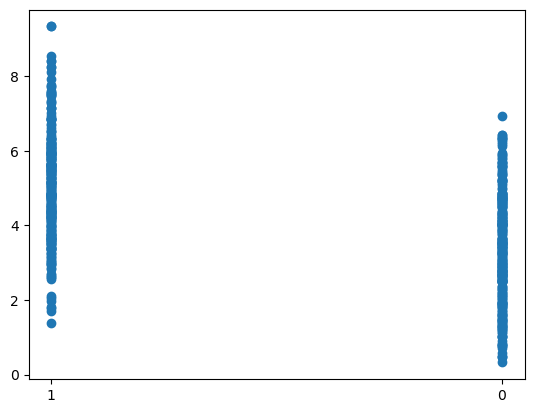

In [7]:
df_gamedata_original['toxic_score'] = df_gamedata['toxic_score'].tolist()
df_win = df_gamedata_original.loc[df_gamedata_original['win'] == '1']
df_loss = df_gamedata_original.loc[df_gamedata_original['win'] == '0']
plt.scatter(df_gamedata_original['win'], df_gamedata_original['toxic_score']);
print(df_win['toxic_score'].mean())
print(df_loss['toxic_score'].mean())